nDCG (Normalized Discounted Cumulative Gain) – популярная метрика в задаче ранжирования, которая учитывает порядок элементов в выдаче. Мы поэтапно разберёмся, что означает каждая буква в данной аббревиатуре, одну за другой реализовав метрики CG, DCG и nDCG.  
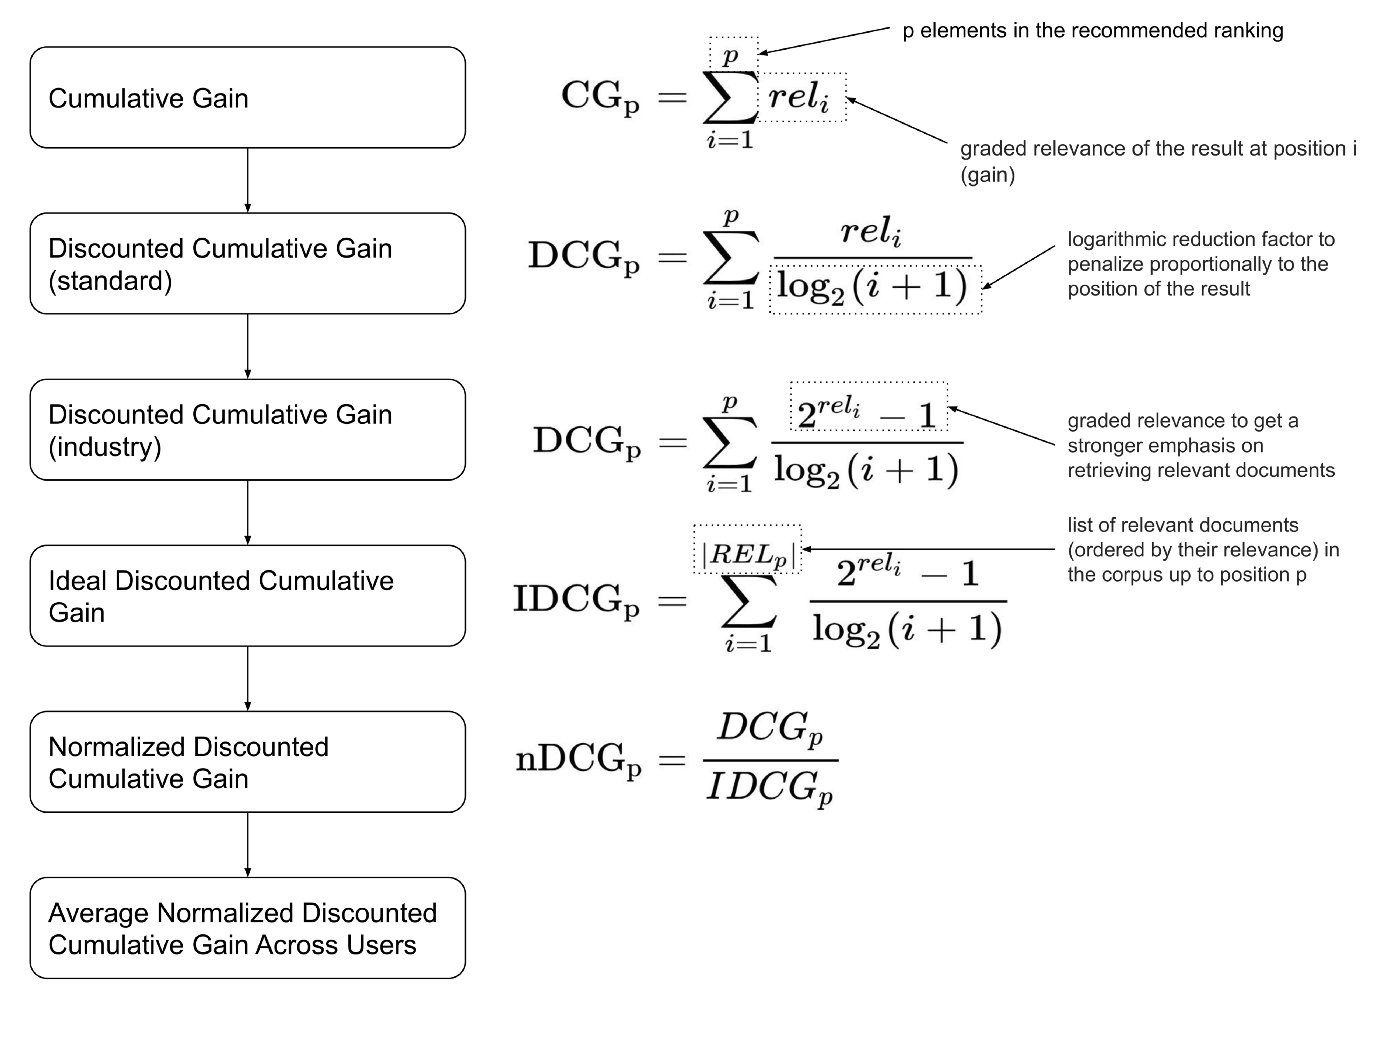

In [1]:
from typing import List

import numpy as np


def cumulative_gain(relevance: List[float], k: int) -> float:
    """Score is cumulative gain at k (CG@k)

    Parameters
    ----------
    relevance:  `List[float]`
        Relevance labels (Ranks)
    k : `int`
        Number of elements to be counted

    Returns
    -------
    score : float
    """
    score = sum(relevance[:k])
    return score

relevance = [0.99, 0.94, 0.88, 0.74, 0.71, 0.68]
k = 5
print(cumulative_gain(relevance, k))

4.26


Отлично, у вас есть инструмент для сравнения двух моделей, Вы берёте топ-5 рекомендаций и смотрите что выдаёт каждая версия на разные типичные запросы. Тут Вы заметили интересный баг, что самое релевантное видео может находиться как на 1-ом месте, так и на 5-ом, и при этом его вклад в метрику одинаков.

Интуитивно кажется, что по ссылке на 5-ом месте будут реже переходить, чем по ссылке на 1-ом.

Как же это учитывать?

Здесь на помощь приходит метрика DCG. Суть её довольно проста: давайте будем добавлять штраф к релевантности если важный документ попал в конец списка или добавлять вес если этот документ попал в начало списка выдачи.
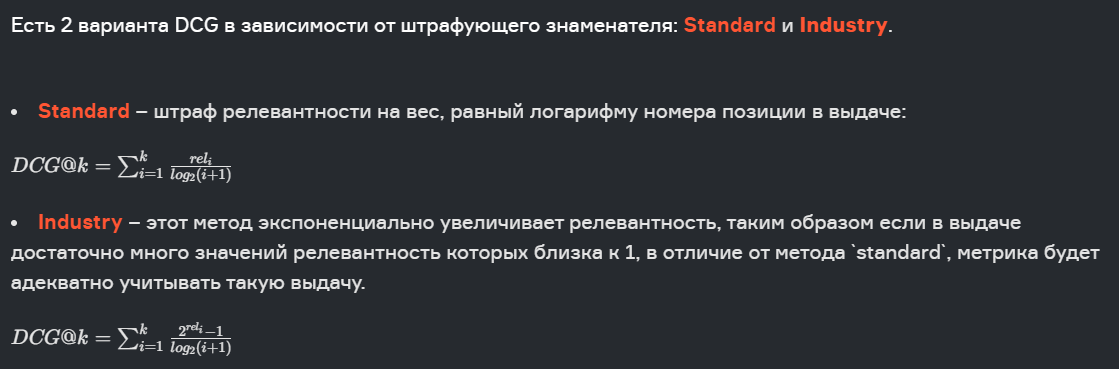

In [7]:
from typing import List

import numpy as np


def discounted_cumulative_gain(relevance: List[float], k: int, method: str = "standard") -> float:
    """Discounted Cumulative Gain

    Parameters
    ----------
    relevance : `List[float]`
        Video relevance list
    k : `int`
        Count relevance to compute
    method : `str`, optional
        Metric implementation method, takes the values​​
        `standard` - adds weight to the denominator
        `industry` - adds weights to the numerator and denominator
        `raise ValueError` - for any value

    Returns
    -------
    score : `float`
        Metric score
    """
    relevance = relevance[:k]
    score = 0
    if method=='standard':
      for i,rel in enumerate(relevance):
        score += rel/np.log2(i+2)
    elif method=='industry':
      for i,rel in enumerate(relevance):
        score += (2**rel-1)/np.log2(i+2)
    else:
      raise ValueError
    return score
  

relevance = [0.99, 0.94, 0.88, 0.74, 0.71, 0.68]
k = 5
method = 'industry'
print(discounted_cumulative_gain(relevance, k, method))

2.520491067899354


Один из простых методов нормирования — поделить на максимальное число. Что если мы посчитаем уже известную нам DCG, но изначально отсортируем релевантности в порядке убывания. Мы получим максимальное значение DCG для конкретного запроса и заданного набора выдачи (параметр k) или IDCG (Ideal Discounted Cumulaive Gain). 

Теперь, что бы получить nDCG (Normalized Discounted Cumulative Gain) достаточно поделить DCG на IDCG, а метрика станет нормированной от 0 до 1.  

In [26]:
from typing import List

import numpy as np


def normalized_dcg(relevance: List[float], k: int, method: str = "standard") -> float:
    """
    Normalized Discounted Cumulative Gain.

    Parameters
    ----------
    relevance : `List[float]`
        Video relevance list
    k : `int`
        Count relevance to compute
    method : `str`, optional
        Metric implementation method, takes the values
        `standard` - adds weight to the denominator
        `industry` - adds weights to the numerator and denominator
        `raise ValueError` - for any value

    Returns
    -------
    score : `float`
        Metric score
    """
    def discounted_cumulative_gain(relevance1: List[float], k: int, method: str = "standard") -> float:
        """Discounted Cumulative Gain

        Parameters
        ----------
        relevance1 : `List[float]`
            Video relevance list
        k : `int`
            Count relevance to compute
        method : `str`, optional
            Metric implementation method, takes the values​​
            `standard` - adds weight to the denominator
            `industry` - adds weights to the numerator and denominator
            `raise ValueError` - for any value

        Returns
        -------
        score : `float`
            Metric score
        """
        relevance1 = relevance1[:k]
        score = 0
        if method=='standard':
          for i,rel in enumerate(relevance1):
            score += rel/np.log2(i+2)
        elif method=='industry':
          for i,rel in enumerate(relevance1):
            score += (2**rel-1)/np.log2(i+2)
        else:
          raise ValueError
        return score
    
    DCG = discounted_cumulative_gain(relevance, k, method)
    relevance = sorted(relevance, reverse=True)
    IDCG = discounted_cumulative_gain(relevance, k, method)
    return DCG/IDCG

relevance = [0.99, 0.94, 0.74, 0.88, 0.71, 0.68]
k = 5
method = 'standard'
print(normalized_dcg(relevance, k, method))

0.9962906539247512


Замечательно! Вы уже умеете сравнивать модели по определенному запросу, и CyberTolya-T800 работает прекрасно. Наш проект растет, как и количество запросов и новых видео, смотреть на какие-то конкретные запросы уже почти не имеет смысл.

Вы сталкиваетесь с проблемой, что смотреть нужно на большое количество запросов и поведение модели в целом. Как же все таки посчитать метрику для множества запросов?

Avarage nDCG - усредненное значение метрики nDCG по каждому запросу из множества. 

In [ ]:
!pip install pycodestyle pycodestyle_magic
!pip install flake8-nb
!flake8-nb

In [1]:
#%%pycodestyle
from typing import List
import numpy as np


def avg_ndcg(list_relevances: List[List[float]],
             k: int, method: str = 'standard') -> float:
    """avarage nDCG

    Parameters
    ----------
    list_relevances : `List[List[float]]`
        Video relevance matrix for various queries
    k : `int`
        Count relevance to compute
    method : `str`, optional
        Metric implementation method, takes the values ​​\
        `standard` - adds weight to the denominator\
        `industry` - adds weights to the numerator and denominator\
        `raise ValueError` - for any value

    Returns
    -------
    score : `float`
        Metric score
    """
    def normalized_dcg(relevance: List[float],
                       k: int, method: str = "standard") -> float:
        """
        Normalized Discounted Cumulative Gain.

        Parameters
        ----------
        relevance : `List[float]`
            Video relevance list
        k : `int`
            Count relevance to compute
        method : `str`, optional
            Metric implementation method, takes the values
            `standard` - adds weight to the denominator
            `industry` - adds weights to the numerator and denominator
            `raise ValueError` - for any value

        Returns
        -------
        score : `float`
            Metric score
        """
        def discounted_cumulative_gain(relevance1: List[float], k: int,
                                       method: str = "standard") -> float:
            """Discounted Cumulative Gain

            Parameters
            ----------
            relevance1 : `List[float]`
                Video relevance list
            k : `int`
                Count relevance to compute
            method : `str`, optional
                Metric implementation method, takes the values​​
                `standard` - adds weight to the denominator
                `industry` - adds weights to the numerator and denominator
                `raise ValueError` - for any value

            Returns
            -------
            score : `float`
                Metric score
            """
            relevance1 = relevance1[:k]
            score = 0
            if method == 'standard':
                for i, rel in enumerate(relevance1):
                    score += rel/np.log2(i+2)
            elif method == 'industry':
                for i, rel in enumerate(relevance1):
                    score += (2**rel-1)/np.log2(i+2)
            else:
                raise ValueError
            return score
        DCG = discounted_cumulative_gain(relevance, k, method)
        relevance = sorted(relevance, reverse=True)
        IDCG = discounted_cumulative_gain(relevance, k, method)
        return DCG/IDCG
    score = 0
    for relevance in list_relevances:
        score += normalized_dcg(relevance, k, method)
    score = score/(len(list_relevances))
    return score


list_relevances = [
        [0.99, 0.94, 0.88, 0.89, 0.72, 0.65],
        [0.99, 0.92, 0.93, 0.74, 0.61, 0.68],
        [0.99, 0.96, 0.81, 0.73, 0.76, 0.69]
    ]
k = 5
method = 'standard'
print(avg_ndcg(list_relevances, k, method))

0.9961322104432755
